# Testing LSH

This notebook covers the implementation (with Numpy) and testing of a traditional LSH process. Covering shingling, MinHashing, and a straightforward LSH banding process for identifying candidate pairs.

The first thing we need is data.

In [1]:
!pip install textdistance[extras]
!pip install plotly

In [2]:
import requests
import pandas as pd
import numpy as np
import sys

np.set_printoptions(threshold=sys.maxsize)

#data = pd.read_csv(io.StringIO(text), sep='\t')
data = pd.read_hdf('signatures.h5', key='key', mode='r')

data.head()

,Path,Title,duration,framerate,clipsize,L,W,H,elapsed_time,process_FPS,coarse_sign,confidence,words,fine_sign,Topic,coarse_sign_hashed,confidence_hashed
0,processed_signatures/127dab55025984673f65d3a23...,127dab55025984673f65d3a23b1fea99ecc79b15.mp4,300.845000,29.968921,103385387,9016,1440,1080,25.666180,351.279389,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[121, 121, 121, 121, 121, 182, 36, 48, 154, 15...","[121, 121, 121, 121, 121, 121, 121, 121, 121, ...",dove_evolution_commercial,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, -92, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
1,processed_signatures/5ac8651ce41781440c8595d17...,5ac8651ce41781440c8595d174748f1a6cad1ff7.flv,64.900000,30.000000,5923082,1948,640,360,5.942043,327.833383,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[129, 130, 129, 129, 126, 130, 138, 127, 134, ...","[194, 119, 225, 95, 215, 194, 122, 234, 107, 2...","[152, 151, 162, 66, 231, 55, 115, 130, 52, 142...",david_beckham_lights_the_olympic_torch,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, -8, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
2,processed_signatures/2fe7b38b1cbdfdf5d6075ee2b...,2fe7b38b1cbdfdf5d6075ee2b2cd9fee2cf7d7c1.flv,142.560000,25.000000,7721187,3565,424,320,11.831021,301.326486,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[111, 111, 111, 111, 111, 108, 110, 110, 109, ...","[106, 215, 175, 202, 236, 106, 215, 175, 202, ...","[117, 36, 12, 0, 84, 84, 19, 33, 209, 136, 35,...",scent_of_woman_tango,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, -59, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
3,processed_signatures/caec7bae88f5b5d60a08487e9...,caec7bae88f5b5d60a08487e9d9a8cd27251c64e.flv,166.233000,29.969697,5991444,4983,320,240,16.579916,300.544350,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[121, 121, 121, 121, 121, 233, 92, 120, 145, 1...","[121, 121, 121, 121, 121, 121, 121, 121, 121, ...",dove_evolution_commercial,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, -9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,processed_signatures/7b2158aad4ea2e6c8f149bb86...,7b2158aad4ea2e6c8f149bb869801b96734c1b1c.flv,99.366000,29.969697,9638711,2979,640,480,10.320174,288.657931,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[121, 121, 121, 121, 121, 121, 121, 121, 121, ...","[121, 121, 121, 121, 121, 121, 121, 121, 121, ...",dove_evolution_commercial,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, -17, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0..."


We will take the text from just one column.

In [3]:
sentences = data['coarse_sign'].tolist()

We have our data, now to shingle and one-hot encode it.

In [4]:
x = sentences[0][:200]
print(x, np.array2string(x, separator='')[1:-1])


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 0000000000000000000000000000000000000000000000000000000000000000000000000
 0000000000000000000000000000000000000000000000001000000000000000000000000
 000000000000000000000000000000000010100000000000000000


In [5]:
def build_shingles(sentence: str, k: int):
    shingles = []
    sentence = np.array2string(sentence, separator='')[1:-1]
    for i in range(len(sentence) - k):
        shingles.append(sentence[i:i+k])
    return set(shingles)

def build_vocab(shingle_sets: list):
    # convert list of shingle sets into single set
    full_set = {item for set_ in shingle_sets for item in set_}
    vocab = {}
    for i, shingle in enumerate(list(full_set)):
        vocab[shingle] = i
    return vocab

def one_hot(shingles: set, vocab: dict):
    vec = np.zeros(len(vocab))
    for shingle in shingles:
        idx = vocab[shingle]
        vec[idx] = 1
    return vec

In [6]:
k = 5  # shingle size

# build shingles
shingles = []
for sentence in sentences:
    shingles.append(build_shingles(sentence, k))

# build vocab
vocab = build_vocab(shingles)

# one-hot encode our shingles
shingles_1hot = []
for shingle_set in shingles:
    shingles_1hot.append(one_hot(shingle_set, vocab))
# stack into single numpy array
shingles_1hot = np.stack(shingles_1hot)
shingles_1hot.shape

(520, 96)

In [7]:
shingles_1hot[:5]

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

In [8]:
sum(shingles_1hot[4])  # confirm we have 1s

85.0

## MinHash

Now we move onto minhashing, first we need to create functions for building a range of minhash vectors, and another to process our sparse vectors through this minhash array - to produce our signatures.

In [9]:
def minhash_arr(vocab: dict, resolution: int):
    length = len(vocab.keys())
    arr = np.zeros((resolution, length))
    for i in range(resolution):
        permutation = np.random.permutation(len(vocab)) + 1
        arr[i, :] = permutation.copy()
    return arr.astype(int)

def get_signature(minhash, vector):
    # get index locations of every 1 value in vector
    idx = np.nonzero(vector)[0].tolist()
    # use index locations to pull only +ve positions in minhash
    shingles = minhash[:, idx]
    # find minimum value in each hash vector
    signature = np.min(shingles, axis=1)
    return signature

In [10]:
arr = minhash_arr(vocab, 50)

signatures = []

for vector in shingles_1hot:
    signatures.append(get_signature(arr, vector))

# merge signatures into single array
signatures = np.stack(signatures)
signatures.shape

(520, 50)

In [11]:
signatures.shape

(520, 50)

## LSH

Finally, we move onto the LSH process. We will use a class here:

In [12]:
from itertools import combinations

class LSH:
    buckets = []
    counter = 0
    def __init__(self, b):
        self.b = b
        for i in range(b):
            self.buckets.append({})

    def make_subvecs(self, signature):
        l = len(signature)
        assert l % self.b == 0
        r = int(l / self.b)
        # break signature into subvectors
        subvecs = []
        for i in range(0, l, r):
            subvecs.append(signature[i:i+r])
        return np.stack(subvecs)
    
    def add_hash(self, signature):
        subvecs = self.make_subvecs(signature).astype(str)
        for i, subvec in enumerate(subvecs):
            subvec = ','.join(subvec)
            if subvec not in self.buckets[i].keys():
                self.buckets[i][subvec] = []
            self.buckets[i][subvec].append(self.counter)
        self.counter += 1

    def check_candidates(self):
        candidates = []
        for bucket_band in self.buckets:
            keys = bucket_band.keys()
            for bucket in keys:
                hits = bucket_band[bucket]
                if len(hits) > 1:
                    candidates.extend(combinations(hits, 2))
        return set(candidates)

In [14]:
b = 10

lsh = LSH(b)

for signature in signatures:
    lsh.add_hash(signature)

In [15]:
#lsh.buckets

Now we've filled our hash buckets all we need to do is loop through each and where we have multiple entries in a single bucket, mark these as our candidate pairs.

In [16]:
candidate_pairs = lsh.check_candidates()
len(candidate_pairs)

130712

In [17]:
list(candidate_pairs)[:5]

[(132, 268), (244, 509), (192, 319), (285, 510), (343, 488)]

We now have all of our candidate pairs!

## Optimizing the Bands

Now let's visualize the actual cosine similarity of our signature vectors against whether we identified the signatures as candidate pairs or not.

(we will also calculate Jaccard but it's less useful here, try both!)

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
import textdistance

def jaccard(a: set, b: set):
    return len(a.intersection(b)) / len(a.union(b))

def hamming_distance(a, b):
    return len([i for i in filter(lambda x: x[0] != x[1], zip(a, b))])

In [19]:
pairs = pd.DataFrame({
    'x': [],
    'y': [],
    'topic_x': [],
    'topic_y': [],
    'jaccard': [],
    'cosine': [],
    'bag': [],
    'candidate': []
})

data_len = shingles_1hot.shape[0]
chosen = set()
# take random sample of pairs
sample_size = 5000
for _ in range(sample_size):
    x, y = np.random.choice(data_len, 2)
    if x == y or (x, y) in chosen: continue
    chosen.add((x, y))
    vector_x = signatures[x]
    vector_y = signatures[y]
    topic_x = data['Topic'][x]
    topic_y = data['Topic'][y]
    candidate = 1 if (x, y) in candidate_pairs else 0
    cosine = cosine_similarity([vector_x], [vector_y])[0][0]
    bag = textdistance.bag(list(vector_x), list(vector_y))
    pairs.loc[len(pairs)]  = {
            'x': x,
            'y': y,
            'topic_x': topic_x,
            'topic_y': topic_y,
            'jaccard': jaccard(set(vector_x), set(vector_y)),
            'cosine': cosine,
            'bag': bag,
            'candidate': candidate
        }

# add a normalized cosine column for better alignment
cos_min = pairs['cosine'].min()
cos_max = pairs['cosine'].max()
pairs['cosine_norm'] = (pairs['cosine'] - cos_min) / (cos_max - cos_min)

<AxesSubplot: xlabel='jaccard', ylabel='candidate'>

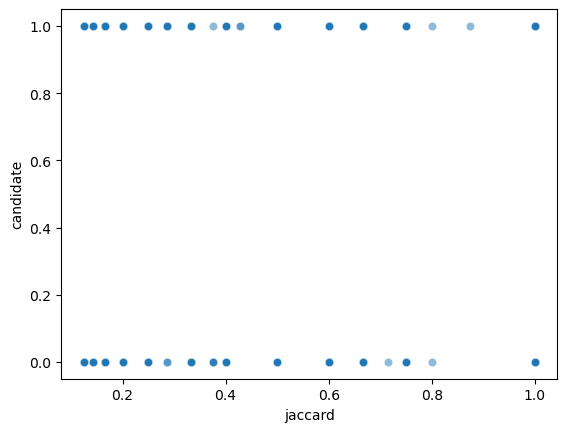

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=pairs, x='jaccard', y='candidate', alpha=0.5)

Now, this is an *interesting* way to visualize our distribution, but we have reason. We can actually tune our LSH function using `b`, and we have a formalized function that tells us the probability of identifying a pair as candidate pairs given their similarity. We calculate this as so:

In [21]:
def probability(s, r, b):
    # s: similarity
    # r: rows (per band)
    # b: number of bands
    return 1 - (1 - s**r)**b

def normalize(x, x_min, x_max):
    return (x - x_min) / (x_max - x_min)

Let's visualize that for our current parameters, alongside our scatter plot.

<AxesSubplot: xlabel='jaccard', ylabel='candidate'>

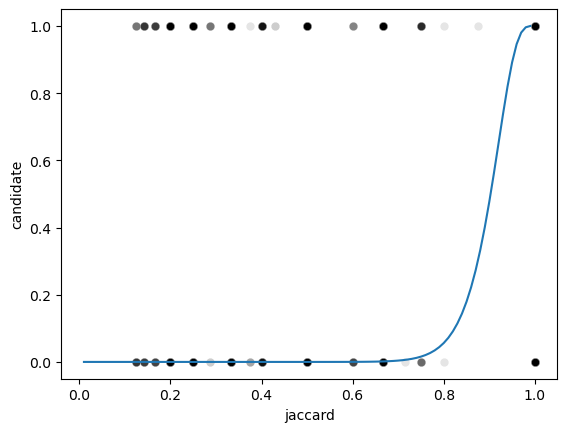

In [33]:
b = 5
r = int(100 / b)
s_scores = np.arange(0.01, 1, 0.01)
P_scores = [probability(s, r, b) for s in s_scores]

sns.lineplot(x=s_scores, y=P_scores)
sns.scatterplot(data=pairs, x='jaccard', y='candidate', alpha=0.1, color='k')

<AxesSubplot: xlabel='jaccard', ylabel='candidate'>

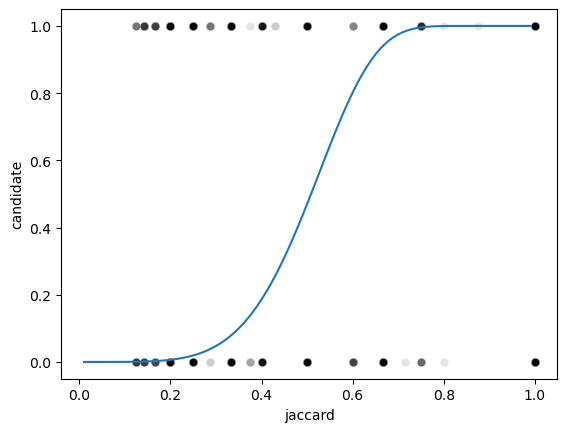

In [34]:
b = 20
r = int(100 / b)
s_scores = np.arange(0.01, 1, 0.01)
P_scores = [probability(s, r, b) for s in s_scores]

sns.lineplot(x=s_scores, y=P_scores)
sns.scatterplot(data=pairs, x='jaccard', y='candidate', alpha=0.1, color='k')

From here we can attempt to modify the similarity threshold `t` - which is the cut-off point on our similarity axes as to where we would like a given cosine similarity to rate as a candidate pair or not.

Let's try a few different band values with our probability formula to see where this balance may be.

/tmp/ipykernel_3410/3561655482.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  probs = probs.append(pd.DataFrame({


<AxesSubplot: xlabel='s', ylabel='P'>

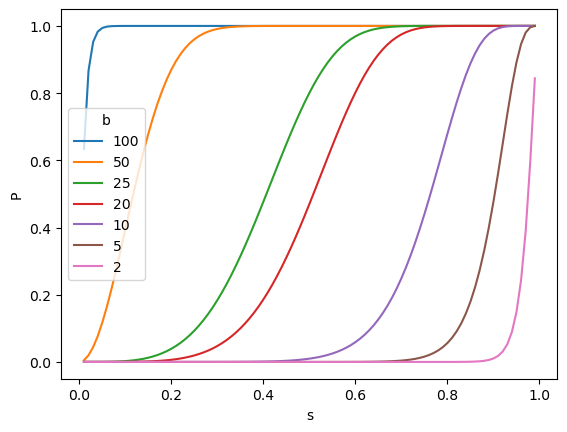

In [24]:
probs = pd.DataFrame({
    'P': [],
    's': [],
    'b': []
})
for b in [100, 50, 25, 20, 10, 5, 2]:
    r = int(100 / b)
    s_scores = np.arange(0.01, 1, 0.01)
    P_scores = [probability(s, r, b) for s in s_scores]
    probs = probs.append(pd.DataFrame({
        'P': P_scores,
        's': s_scores,
        'b': [str(b)]*len(s_scores)
    }), ignore_index=True)

sns.lineplot(data=probs, x='s', y='P', hue='b')

So a `b` value of `20` have us a threshold value `t` slightly too high (depending on our definition of 'similar'), so maybe we can use `b == 25` to get a better distribution of our candidate pairs.

Let's try:

In [25]:
b = 25

lsh = LSH(b)

for signature in signatures:
    lsh.add_hash(signature)

candidate_pairs = lsh.check_candidates()
len(candidate_pairs)

134940

In [26]:
pairs = pd.DataFrame({
    'x': [],
    'y': [],
    'topic_x': [],
    'topic_y': [],
    'jaccard': [],
    'cosine': [],
    'bag':[],
    'tversky':[],
    'tanimoto':[],
    'hamming':[],
    'candidate': []
})

data_len = shingles_1hot.shape[0]
chosen = set()
# take random sample of pairs
sample_size = 50_00
for _ in range(sample_size):
    x, y = np.random.choice(data_len, 2)
    if x == y or (x, y) in chosen: continue
    chosen.add((x, y))
    vector_x = signatures[x]
    vector_y = signatures[y]
    topic_x = data['Topic'][x]
    topic_y = data['Topic'][y]
    candidate = 1 if (x, y) in candidate_pairs else 0
    cosine = cosine_similarity([vector_x], [vector_y])[0][0]
    bag = textdistance.bag(list(vector_x), (vector_y))
    tversky = textdistance.tversky(list(vector_x), list(vector_y))
    tanimoto = textdistance.tanimoto(list(vector_x), list(vector_y))
    hamming = hamming_distance(list(vector_x), list(vector_y))
    
    pairs.loc[len(pairs)] = {
            'x': x,
            'y': y,
            'topic_x': topic_x,
            'topic_y': topic_y,
            'jaccard': jaccard(set(vector_x), set(vector_y)),
            'cosine': cosine,
            'bag': bag,
            'tversky': tversky,
            'tanimoto': tanimoto,
            'hamming': hamming,
            'candidate': candidate
        }

# add a normalized cosine column for better alignment
cos_min = pairs['cosine'].min()
cos_max = pairs['cosine'].max()
pairs['cosine_norm'] = (pairs['cosine'] - cos_min) / (cos_max - cos_min)
pairs['TP'] = 0
pairs['TP'][pairs['topic_x']==pairs['topic_y']] = 1

/tmp/ipykernel_3410/1625749228.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairs['TP'][pairs['topic_x']==pairs['topic_y']] = 1


<AxesSubplot: xlabel='jaccard', ylabel='TP'>

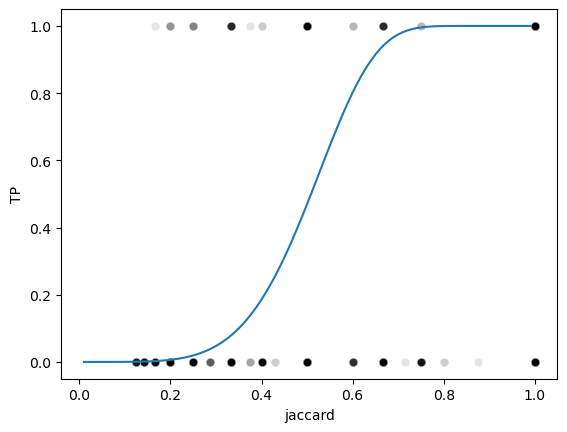

In [35]:
r = int(100 / b)
s_scores = np.arange(0.01, 1, 0.01)
P_scores = [probability(s, r, b) for s in s_scores]

sns.lineplot(x=s_scores, y=P_scores)
sns.scatterplot(data=pairs, x='jaccard', y='TP', alpha=0.1, color='k')

<AxesSubplot: xlabel='cosine_norm', ylabel='TP'>

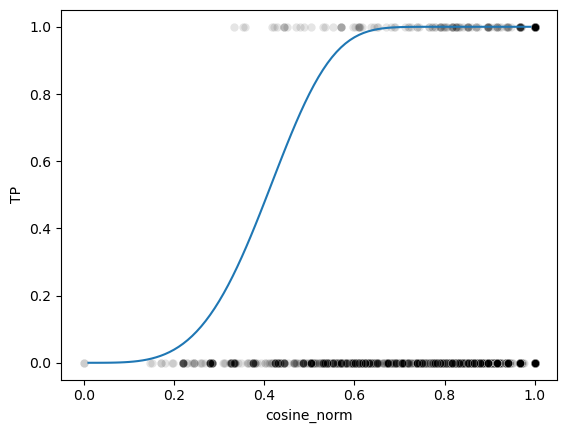

In [28]:
r = int(100 / b)
s_scores = np.arange(0.01, 1, 0.01)
P_scores = [probability(s, r, b) for s in s_scores]

sns.lineplot(x=s_scores, y=P_scores)
sns.scatterplot(data=pairs, x='cosine_norm', y='TP', alpha=0.1, color='k')

Shifting from `b == 20` to `b == 25` has reduced the number of non-candidates around `0.7 - 0.8`, and we can see that the number of candidate pairs in total has increased significantly too, from `7468` to `19436`.

Now, in our own use-cases, the preferred similarity threshold will of-course change.

It's also worth noting that different similarity metrics will produce different charts:

In [29]:
pairs

,x,y,topic_x,topic_y,jaccard,cosine,bag,tversky,tanimoto,hamming,candidate,cosine_norm,TP
0,228,476,the_legend_of_1900_magic_waltz,baggio_penalty_1994,0.500000,0.982708,2,0.923077,-0.115477,2,1,0.940594,0
1,438,104,maradona_hand_of_god,the_pursuit_of_happyness_-_job_interview,0.500000,0.964764,5,0.818182,-0.289507,5,0,0.878949,0
2,245,150,scent_of_woman_tango,t-mac_13_points_in_35_seconds,1.000000,1.000000,0,1.000000,0.000000,0,0,1.000000,0
3,384,313,maradona_hand_of_god,saving_private_ryan_omaha_beach,0.333333,0.924185,14,0.562500,-0.830075,14,0,0.739544,0
4,68,302,the_last_samurai_last_battle,beckham_70_yard_goal,0.500000,0.990712,1,0.960784,-0.057715,1,1,0.968091,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4935,505,404,beckham_70_yard_goal,scent_of_woman_tango,1.000000,1.000000,0,1.000000,0.000000,0,0,1.000000,0
4936,262,232,president_obama_takes_oath,titanic_fly_scene,1.000000,1.000000,0,1.000000,0.000000,0,0,1.000000,0
4937,7,82,maradona_hand_of_god,endless_love,1.000000,1.000000,0,1.000000,0.000000,0,1,1.000000,0
4938,442,421,tom_hanks_winning_an_oscar,obama_kicks_door,0.500000,0.950871,9,0.694915,-0.525091,9,0,0.831222,0


<AxesSubplot: xlabel='jaccard', ylabel='TP'>

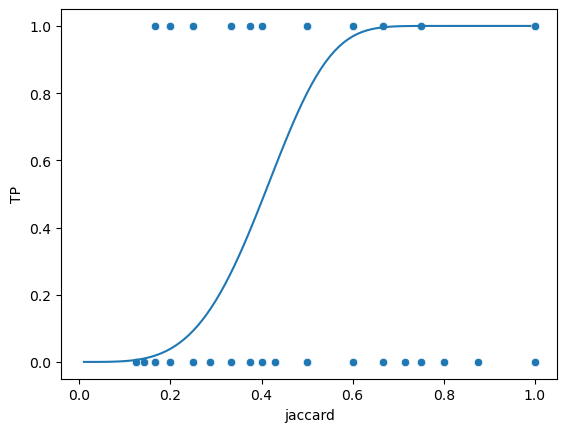

In [30]:
r = int(100 / b)
s_scores = np.arange(0.01, 1, 0.01)
P_scores = [probability(s, r, b) for s in s_scores]

sns.lineplot(x=s_scores, y=P_scores)
sns.scatterplot(data=pairs, x='jaccard', y='TP')

In [36]:
import plotly.offline as py
import plotly.graph_objs as go
import plotly.io as pio
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px
import plotly.figure_factory as ff
fig = go.Figure()


np.set_printoptions(threshold=sys.maxsize)
py.init_notebook_mode(connected=True)
pio.renderers.default = 'colab'

y_label='jaccard'
x_label='cosine'
for topic in np.unique(pairs['TP']):
    chart_df = pairs[(pairs['TP']==topic)]
    fig.add_trace(
        go.Scatter(
            x=pd.to_numeric(chart_df[x_label]),
            y=pd.to_numeric(chart_df[y_label]),
            mode="markers",
            #name=topic,
            #marker=dict(color=pairs['TP']),
            text=chart_df[['topic_x', 'topic_y', y_label]],
            hovertemplate='<b>%{text}</b>',
            showlegend=True
        )
)

fig.update_layout(
    autosize=False,
    width=1500,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.update_xaxes(
        tickangle = 90,
        title_text = x_label,
        title_font = {"size": 20},
        title_standoff = 25)

fig.update_yaxes(
        title_text = y_label,
        title_font = {"size": 20},
        title_standoff = 25)
fig.show()